# Hierarchical Bayesian sparse coding

\begin{equation}
    \begin{cases}
        \pmb{v}^{(n)}_L & = \pmb{z}^{(n)}_L  \\
        \pmb{s}^{(n)}_L & = ReLU( f\left(\pmb{v}^{(n)}_L \right) - \gamma_L) \\ 
        \pmb{v}^{(n)}_{L-1} &= \pmb{W}_L \pmb{s}^{(n)}_L + \pmb{z}^{(n)}_{L-1} \\
        & \vdots \\ 
        \pmb{v}^{(n)}_{1} &= \pmb{W}_2 \pmb{s}^{(n)}_2 + \pmb{z}^{(n)}_1 \\
        \pmb{s}^{(n)}_1 & = ReLU( f\left(\pmb{v}^{(n)}_1 \right) - \gamma_1) \\
        \pmb{y}^{(n)} &= \pmb{W}_1 \pmb{s}^{(n)}_1 + \pmb{z}^{(n)}_0 
    \end{cases}
\end{equation}

# Dynamic Bayesian sparse coding

\begin{equation}
 \begin{split}
    \pmb{v}^{(n)} & \sim \mathcal{N}\left(0, \mathbb{I} \right) \\
    \dot{\pmb{x}}^{(n)} & = \pmb{\beta} \left( \pmb{v}^{(n)} -  \pmb{x}^{(n)} \right)  +  \pmb{\omega}^{(n)} \\
    \pmb{s}^{(n)} &= ReLU( f\left(\pmb{x}^{(n)}\right) - \gamma) \\
    \pmb{y}^{(n)} &= \pmb{W} \pmb{s}^{(n)} + \pmb{z}^{(n)}
 \end{split}
\end{equation}

where $f(x) = \ln \left( 1 + e^{-a \cdot x}  \right)$, and $a = 1.702$. Note that in a steady state $P_{\infty}\left( \pmb{x}^{(n)}\right) = \mathcal{N}\left( \pmb{v}^{(n)}, \pmb{\Sigma} \right)$ with
\begin{equation}
\text{vec}\left( \pmb{\Sigma} \right) = \left( \pmb{\beta} ⊕ \pmb{\beta} \right) ^{-1} \cdot \text{vec}\left( \pmb{\sigma} \pmb{\sigma}^T \right)
\end{equation}

Alternatively we can consider the following setup

\begin{equation}
 \begin{split}
    \pmb{v}^{(n)} & \sim \mathcal{N}\left(0, \mathbb{I} \right) \\
    \pmb{s}^{(n)} &= ReLU( f\left(\pmb{v}^{(n)}\right) - \gamma) \\
    \dot{\pmb{x}}^{(n)} & = \pmb{\beta} \left( \pmb{W}\pmb{s}^{(n)} -  \pmb{x}^{(n)} \right)  +  \pmb{\omega}^{(n)} \\
    \pmb{y}^{(n)} &= \pmb{x}^{(n)} + \pmb{z}^{(n)}
 \end{split}
\end{equation}

Therefore we have that in a steady state 
$$P_{\infty}\left( \pmb{x}^{(n)}\right) = \mathcal{N}\left( \pmb{W}\pmb{s}^{(n)}, \pmb{\Sigma} \right)$$

And we get an equivalence with the static formulation ($\pmb{x}^{(n)}_\infty = \pmb{v}^{(n)}$) when $\pmb{\Sigma} = \sigma \mathbb{I}$. 


In [1]:
import os
# Set cuda device to use
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

####################
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
######################################################

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

import jax.numpy as jnp
from functools import partial
from jax import random, vmap, nn
from jax.nn import one_hot
from flax import linen as fnn
from typing import Any, Callable, Sequence, Optional

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
from numpyro import handlers
from numpyro.contrib.control_flow import scan

sns.set(context='notebook')

rng_key = random.PRNGKey(111)

## State space models

In [3]:
from jax import jit, grad

@jit
def f(x, a=1.702):
    # approximating for 0.5 * ( 1 + erf(x/jnp.sqrt(2))) with - \ln (sigmoid(ax)) = sofplus(- ax)
    return nn.softplus( - a * x)  

jit_grad_f = jit(grad(f))
print(jit_grad_f(-0.))

%timeit jit_grad_f(-0.)

-0.851
2.29 ms ± 12.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


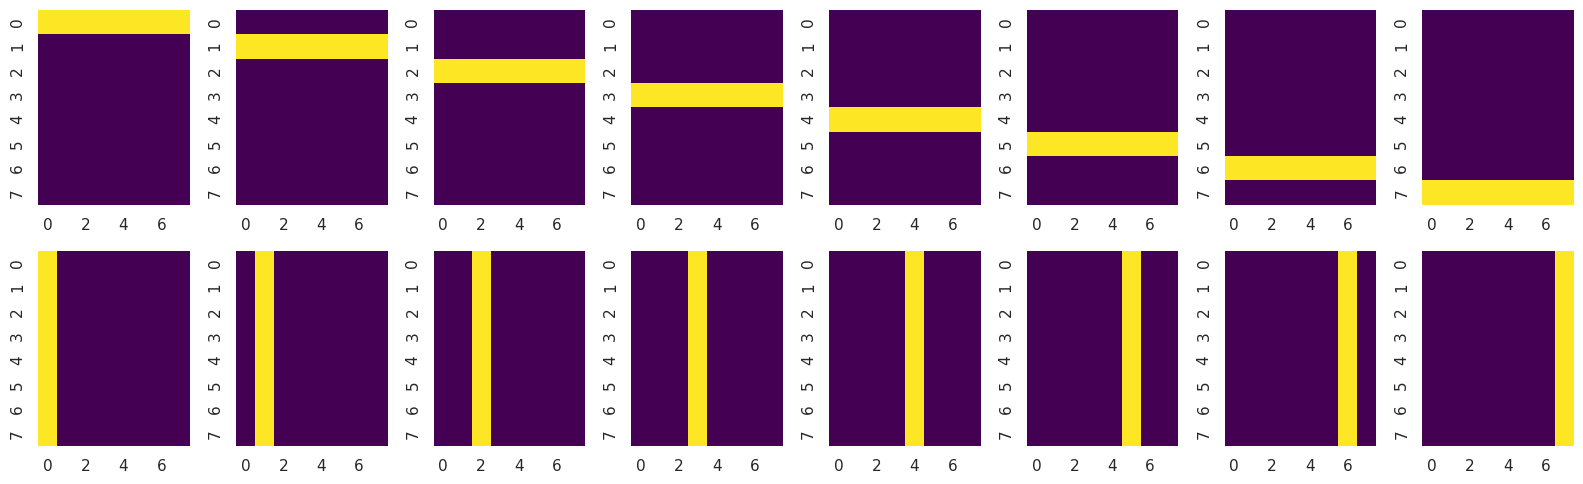

In [4]:
d = 8
tmp = nn.one_hot(jnp.arange(d), d)
W = jnp.stack([ tmp[:, i][:, None].repeat(d, axis=-1) for i in range(d)] + [ tmp[i][None].repeat(d, axis=0) for i in range(d)])

fig, axes = plt.subplots(2, 8, figsize=(16, 5))

for i, w in zip(range(len(W)), W):
    sns.heatmap(w, ax=axes.flatten()[i], cbar=False, vmax=1, vmin=0, cmap='viridis')

fig.tight_layout()

In [5]:
from jax.scipy.linalg import expm

def global_vars(d, k, m, dt=1.):
    u = numpyro.sample('u', dist.Gamma(1, 1))
    
    sig = numpyro.sample('sig', dist.Gamma(1/2, 1).expand([2]).to_event(1))
    scale = numpyro.deterministic('scale', jnp.sqrt(sig[0]/sig[1]) )

    _lam = numpyro.sample('_lam', dist.Gamma(1/2, 1).expand([2]).to_event(1))
    lam = numpyro.deterministic('lam', jnp.sqrt(_lam[0]/_lam[1]))
    
    _tau = numpyro.sample('_tau', dist.Gamma(1/2, 1).expand([2, d]).to_event(2))
    tau = numpyro.deterministic('tau', jnp.sqrt(_tau[0]/_tau[1]))
    
    with numpyro.plate('dim', d):
        _W = numpyro.sample('W_base', dist.Normal(0, 1).expand([k, m]).to_event(2))
    
    s = 1e-2 * lam * jnp.expand_dims(tau, (-1, -2))
    W = numpyro.deterministic('W', s * _W)

    theta = numpyro.sample('theta', dist.Gamma(1., 1.).expand([d]).to_event(1))
    _omega = numpyro.sample('_omega', dist.LKJCholesky(d))
    Omega = _omega - _omega.T
    B = numpyro.deterministic('B', jnp.diag(jnp.exp( - dt * theta)) @ expm(- dt * Omega))

    S = numpyro.sample('S', dist.HalfCauchy(1.).expand([d]).to_event(1))
    L_corr = numpyro.sample('L_corr', dist.LKJCholesky(d))
    L = jnp.expand_dims(S, -1) * L_corr
    
    return W, B, L.T, scale, u

def local_vars(W, z, scale, u):
    d, k, m = W.shape
    s = numpyro.deterministic('s_t', nn.relu( f(z) - u ) )

    loc = numpyro.deterministic('loc_t', (s @ W.reshape(d, -1)).reshape(-1, k, m))
    numpyro.sample('obs_t', dist.Normal(loc, scale).to_event(2))

def model(t=32, n=100, d=16, k=8, m=8):
    W, B, L, scale, u = global_vars(d, k, m)

    x0 = numpyro.sample('x0', dist.Normal(0, 1).expand([n, d]).to_event(1))
    v = numpyro.sample('v', dist.Normal(0, 1).expand([n, d]).to_event(1))

    def step_fn(carry, t):
        _x = carry
        with numpyro.plate('data', n):
            eps = numpyro.sample('eps_t', dist.Normal(0., 1.).expand([d]).to_event(1))
            x_t = _x @ B + eps @ L
            local_vars(W, _x + v, scale, u)
        
        return x_t, None
    
    scan(step_fn, x0, jnp.arange(t))

pred = Predictive(numpyro.handlers.condition(model, data={'W_base': W, 'u': - jnp.log(0.2), 'sig': jnp.array([0.01, 1.])}), num_samples=1)
rng_key, key = random.split(rng_key)
sample = pred(key)

%timeit pred(key)

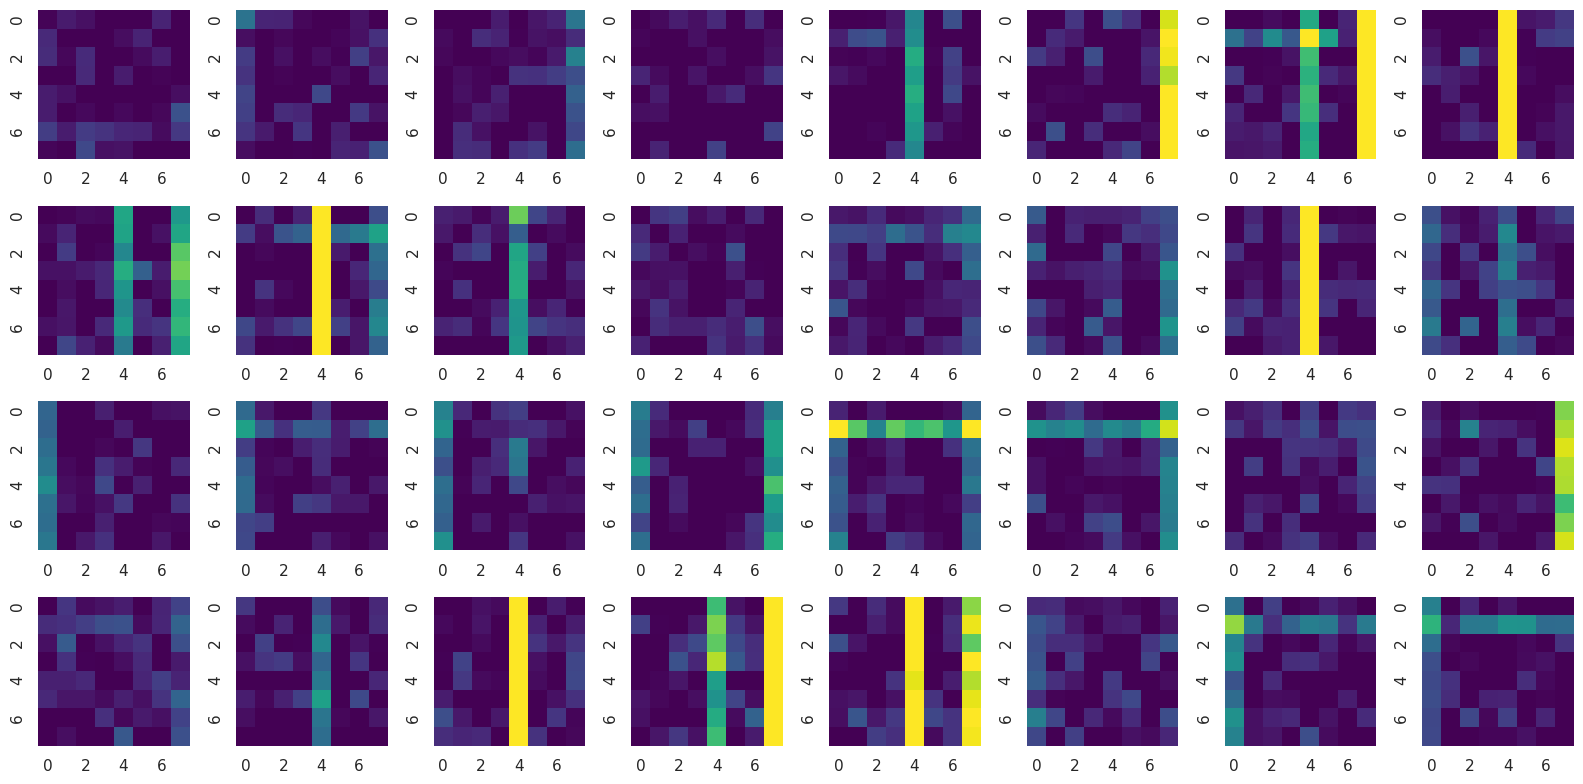

In [77]:
obs = sample['obs_t'][0, :, 10]

fig, axes = plt.subplots(4, 8, figsize=(16, 8))

for i in range(32):
    sns.heatmap(obs[i], ax=axes.flatten()[i], cbar=False, vmax=1, vmin=0, cmap='viridis')

fig.tight_layout()

In [78]:
cond_model = handlers.condition(model, data={'obs_t': sample['obs_t'][0]})

mcmc = MCMC(NUTS(cond_model), num_warmup=200, num_samples=100, progress_bar=True)

rng_key, key = random.split(rng_key)
mcmc.warmup(key, collect_warmup=True, d=24)
warm_smpl = mcmc.get_samples()

rng_key, key = random.split(rng_key)
mcmc.run(key, d=24)
post_smpl = mcmc.get_samples()

sample: 100%|██████████| 100/100 [06:04<00:00,  3.65s/it, 1023 steps of size 4.03e-07. acc. prob=0.92]


(0.0, 50.0)

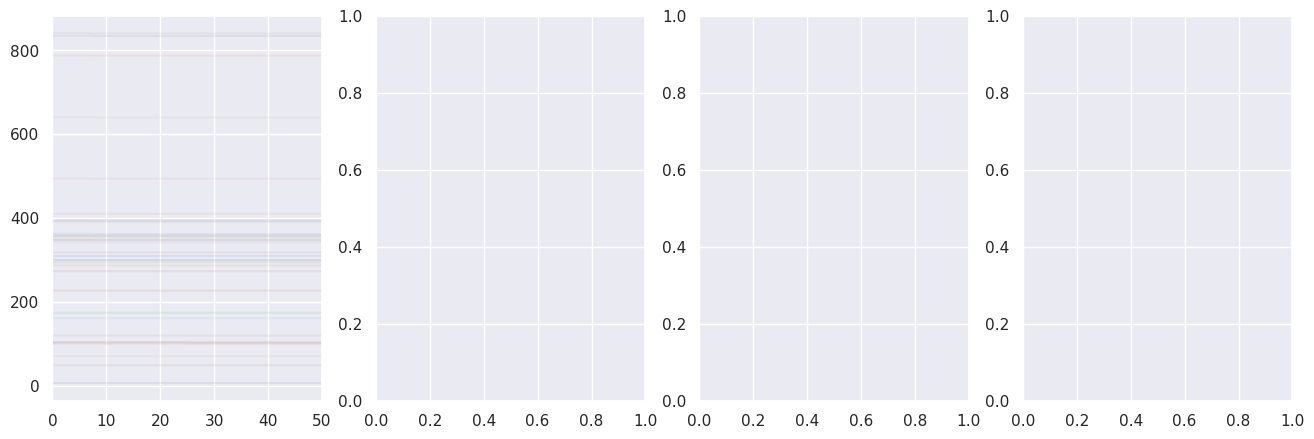

In [11]:
s_t = jnp.concatenate([warm_smpl['s_t'], post_smpl['s_t']], axis=0)

fix, axes = plt.subplots(1, 4, figsize=(16, 5))

axes[0].plot(s_t.mean(-1)[..., 1], alpha=0.1);
axes[0].set_xlim([0, 50])


# s = s_t[..., 0, :, :]
# axes[1].hist(s[s > 0], bins=100, density=True);

# s = s_t[..., 10, :, :]
# axes[2].hist(s[s > 0], bins=100, density=True);

# s = s_t[..., 50, :, :]
# axes[3].hist(s[s > 0], bins=100, density=True);

In [ ]:
# number of generalized coordinates
m = 3

# number of dimensions 
d = 10

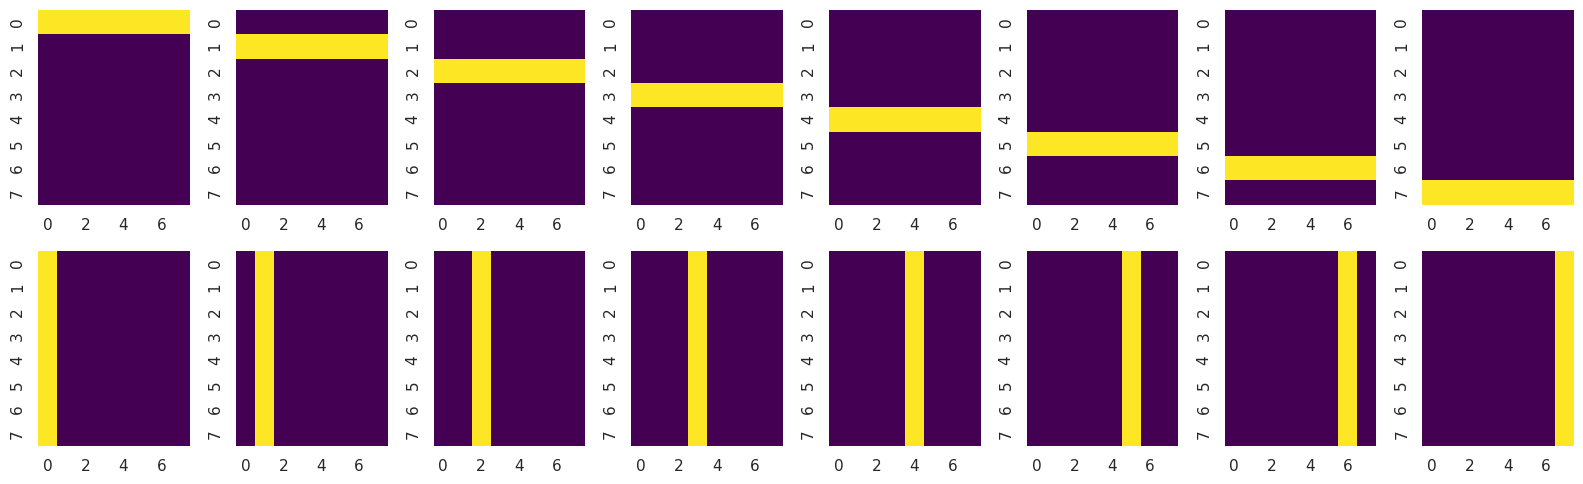

In [ ]:
d = 8
tmp = nn.one_hot(jnp.arange(d), d)
W = jnp.stack([ tmp[:, i][:, None].repeat(d, axis=-1) for i in range(d)] + [ tmp[i][None].repeat(d, axis=0) for i in range(d)])

fig, axes = plt.subplots(2, 8, figsize=(16, 5))

for i, w in zip(range(len(W)), W):
    sns.heatmap(w, ax=axes.flatten()[i], cbar=False, vmax=1, vmin=0, cmap='viridis')

fig.tight_layout()

In [ ]:
from jax import jit, grad
from jax.scipy.special import erf

@jit
def f(x, a=1.702):
    z = nn.sigmoid(a * x)  # approx for 0.5 * ( 1 + erf(x/jnp.sqrt(2)))
    return - jnp.log(z)

jit_grad_f = jit(grad(f))
print(jit_grad_f(-0.))

%timeit jit_grad_f(-0.)

-0.851
69.8 µs ± 2.91 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


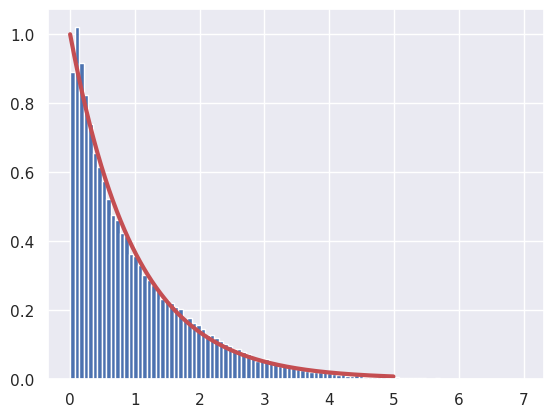

In [ ]:
x = random.normal(random.PRNGKey(0), shape=(100_000,))
y = f(x)
plt.hist(y, bins=100, density=True);
x = jnp.arange(0, 5, 0.01)
plt.plot(x, jnp.exp(-x), 'r', lw=3)

In [ ]:
import numpyro.distributions as dist
from numpyro.infer import Predictive
from jax.scipy.special import erfc, erf

scale = 0.5
u = - jnp.log(0.2)

def _model(W, n=100):

    d, k, m = W.shape

    with numpyro.plate('data', n):
        z = numpyro.sample('z', dist.Exponential(1.).expand([d]).to_event(1))
        s = numpyro.deterministic('s', nn.relu( z - u ) )

        loc = (s @ W.reshape(d, -1)).reshape(n, k, m)
        numpyro.sample('obs', dist.Normal(loc, scale).to_event(2))


def global_vars(d, k, m):
    u = numpyro.sample('u', dist.Gamma(1, 1))
    
    sig = numpyro.sample('sig', dist.Gamma(1/2, 1).expand([2]).to_event(1))
    scale = numpyro.deterministic('scale', jnp.sqrt(sig[0]/sig[1]) )

    _v = numpyro.sample('_v', dist.Gamma(1/2, 1).expand([2]).to_event(1))
    v = numpyro.deterministic('v', jnp.sqrt(_v[0]/_v[1]))
    
    _tau = numpyro.sample('_tau', dist.Gamma(1/2, 1).expand([2, d]).to_event(2))
    tau = numpyro.deterministic('tau', jnp.sqrt(_tau[0]/_tau[1]))
    
    with numpyro.plate('dim', d):
        _W = numpyro.sample('W_base', dist.Normal(0, 1).expand([k, m]).to_event(2))
    
    s = 1e-2 * v * jnp.expand_dims(tau, (-1, -2))
    W = numpyro.deterministic('W', s * _W)
    
    return W, scale, u

def local_vars(W, scale, u):
    d, k, m = W.shape
    z = numpyro.sample('z', dist.Gamma(1, 1).expand([d]).to_event(1))
    s = numpyro.deterministic('s', nn.relu( z - u ) )

    loc = numpyro.deterministic('loc', (s @ W.reshape(d, -1)).reshape(-1, k, m))
    numpyro.sample('obs', dist.Normal(loc, scale).to_event(2))

def local_vars1(W, scale, u):
    d, k, m = W.shape
    z = numpyro.sample('z', dist.Normal(0, 1).expand([d]).to_event(1))
    s = numpyro.deterministic('s', nn.relu( f(z) - u ) )

    loc = numpyro.deterministic('loc', (s @ W.reshape(d, -1)).reshape(-1, k, m))
    numpyro.sample('obs', dist.Normal(loc, scale).to_event(2))

def local_vars2(W, scale, u):
    d, k, m = W.shape
    _z = numpyro.sample('_z', dist.Gamma(1, 1).expand([d, 2]).to_event(2))
    z = numpyro.deterministic('z', jnp.log(1 + _z[..., 0]/_z[..., 1]))
    s = numpyro.deterministic('s', nn.relu( z - u ) )

    loc = numpyro.deterministic('loc', (s @ W.reshape(d, -1)).reshape(-1, k, m))
    numpyro.sample('obs', dist.Normal(loc, scale).to_event(2))

def model(n=100, d=16, k=8, m=8):
    W, scale, u = global_vars(d, k, m)
    with numpyro.plate('data', n):
        local_vars(W, scale, u)

def model1(n=100, d=16, k=8, m=8):
    W, scale, u = global_vars(d, k, m)
    with numpyro.plate('data', n):
        local_vars1(W, scale, u)

def model2(n=100, d=16, k=8, m=8):
    W, scale, u = global_vars(d, k, m)
    with numpyro.plate('data', n):
        local_vars2(W, scale, u)

rng_key = random.PRNGKey(0)
rng_key, _rng_key = random.split(rng_key)
pred = Predictive(_model, num_samples=1)
smpl = pred(_rng_key, W)

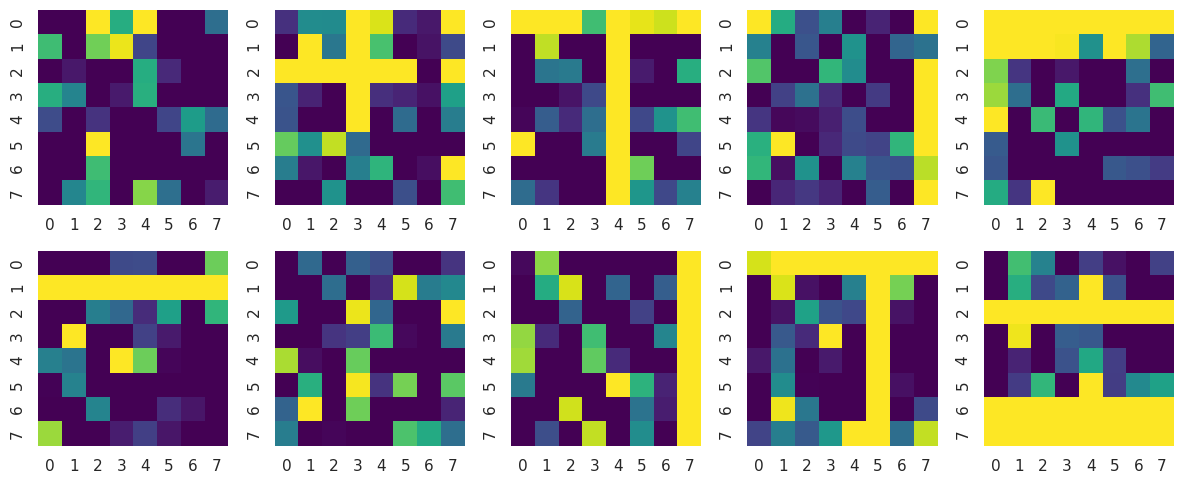

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(12, 5))

O = smpl['obs'][0]

for i, w in enumerate(O[:10]):
    sns.heatmap(w, ax=axes.flatten()[i], cbar=False, vmax=1, vmin=0, cmap='viridis')

fig.tight_layout()

In [ ]:
def sample_posterior(model, W, scale, u, obs, key):
    cm = handlers.condition(local_vars, data={'obs': obs})

    mcmc = MCMC(NUTS(cm), num_warmup=100, num_samples=200, progress_bar=False)
    rng_key, _rng_key = random.split(key)
    mcmc.warmup(_rng_key, W, scale, u, collect_warmup=True)
    warm_smpl = mcmc.get_samples()
    rng_key, _rng_key = random.split(rng_key)
    mcmc.run(_rng_key, W, scale, u)
    post_smpl = mcmc.get_samples()

    return jnp.concatenate([warm_smpl['s'], post_smpl['s']], axis=0)

obs = smpl['obs'][0]
n = obs.shape[0]

In [ ]:
rng_key, _rng_key = random.split(rng_key)
smpl_post = partial(sample_posterior, local_vars, W, scale, u)
post_smpls1 = vmap(smpl_post)(obs, random.split(_rng_key, n))

In [ ]:
rng_key, _rng_key = random.split(rng_key)
smpl_post = partial(sample_posterior, local_vars1, W, scale, u)
post_smpls2 = vmap(smpl_post)(obs, random.split(_rng_key, n))

In [ ]:
rng_key, _rng_key = random.split(rng_key)
smpl_post = partial(sample_posterior, local_vars2, W, scale, u)
post_smpls3 = vmap(smpl_post)(obs, random.split(_rng_key, n))

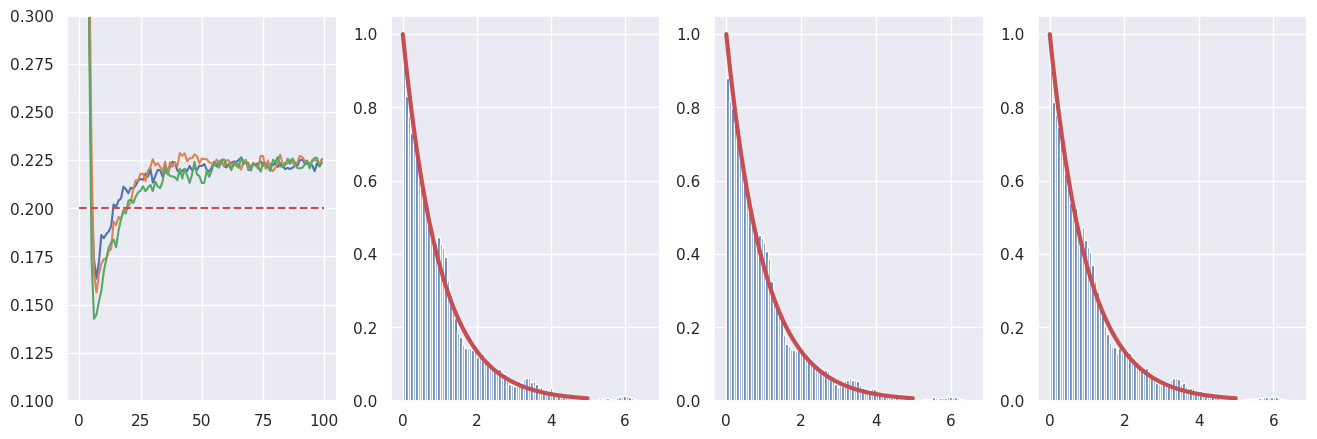

In [ ]:
fix, axes = plt.subplots(1, 4, figsize=(16, 5))

axes[0].plot(post_smpls1.mean(0).mean(-1)[:100])
axes[0].plot(post_smpls2.mean(0).mean(-1)[:100])
axes[0].plot(post_smpls3.mean(0).mean(-1)[:100])
axes[0].hlines(0.2, 0, 100, 'r', linestyle='--')
axes[0].set_ylim([.1, .3])

x = jnp.arange(0, 5, 0.01)

s = post_smpls1[:, 100:]
axes[1].hist(s[s > 0], bins=100, density=True);
axes[1].plot(x, jnp.exp(-x), 'r', lw=3);

s = post_smpls2[:, 100:]
axes[2].hist(s[s > 0], bins=100, density=True);
axes[2].plot(x, jnp.exp(-x), 'r', lw=3);

s = post_smpls3[:, 100:]
axes[3].hist(s[s > 0], bins=100, density=True);
axes[3].plot(x, jnp.exp(-x), 'r', lw=3);


In [ ]:
cm = handlers.condition(model, data={'obs': smpl['obs'][0]})
kernel = NUTS(cm)

mcmc = MCMC(kernel, num_warmup=900, num_samples=100)

rng_key, _rng_key = random.split(rng_key)
mcmc.warmup(_rng_key, collect_warmup=True, d=32)
warm_smpl = mcmc.get_samples()
rng_key, _rng_key = random.split(rng_key)
mcmc.run(random.PRNGKey(0), d=32)

post_smpl = mcmc.get_samples()

sample: 100%|██████████| 100/100 [00:46<00:00,  2.13it/s, 1023 steps of size 3.90e-03. acc. prob=0.82]


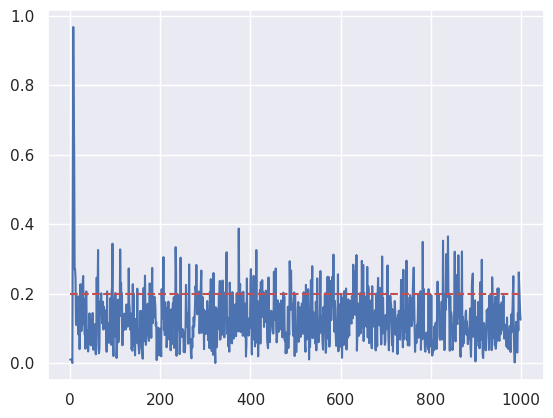

In [ ]:
n = 0
plt.plot( jnp.concatenate([warm_smpl['s'][:, n].mean(-1), post_smpl['s'][:, n].mean(-1)]) )
plt.hlines(0.2, 0, 1000, 'r', linestyle='--')

sample: 100%|██████████| 500/500 [03:48<00:00,  2.19it/s, 1023 steps of size 5.17e-03. acc. prob=0.83]


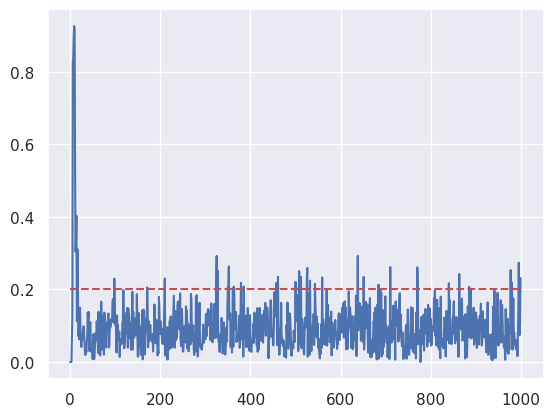

In [ ]:
cm = handlers.condition(model1, data={'obs': smpl['obs'][0]})
kernel = NUTS(cm)

mcmc = MCMC(kernel, num_warmup=500, num_samples=500)

rng_key = random.PRNGKey(0) 
rng_key, _rng_key = random.split(rng_key)
mcmc.warmup(_rng_key, collect_warmup=True, d=32)
warm_smpl = mcmc.get_samples()
rng_key, _rng_key = random.split(rng_key)
mcmc.run(random.PRNGKey(0), d=32)

post_smpl = mcmc.get_samples()

n = 0
plt.plot( jnp.concatenate([warm_smpl['s'][:, n].mean(-1), post_smpl['s'][:, n].mean(-1)]) )
plt.hlines(0.2, 0, 1000, 'r', linestyle='--')

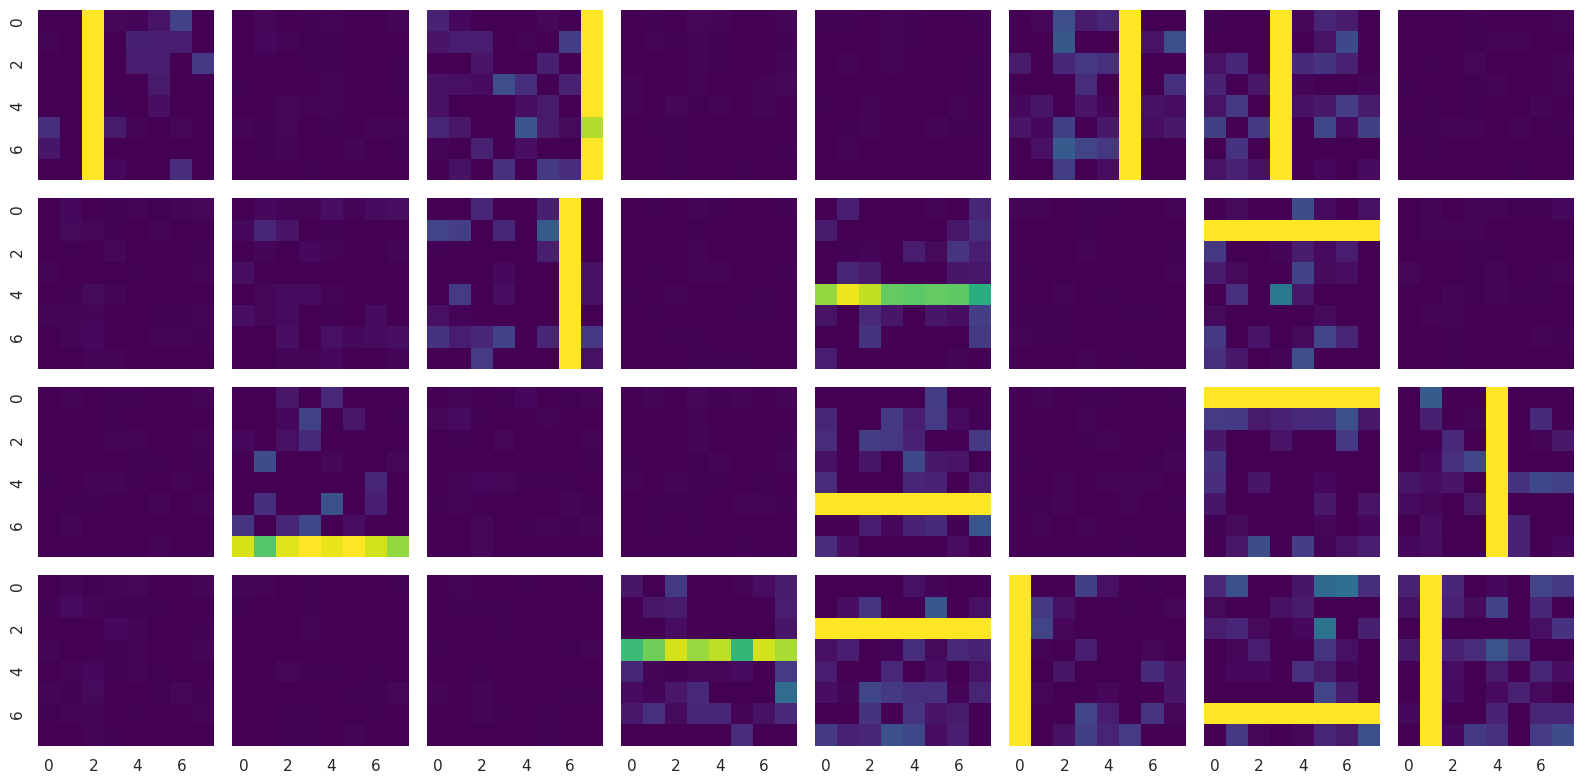

In [ ]:
W_post = post_smpl['W'].mean(0)

fig, axes = plt.subplots(4, 8, figsize=(16, 8), sharex=True, sharey=True)

for i, w in enumerate(W_post):
    sns.heatmap(w, ax=axes.flatten()[i], cbar=False, vmax=1, vmin=0, cmap='viridis')

fig.tight_layout()

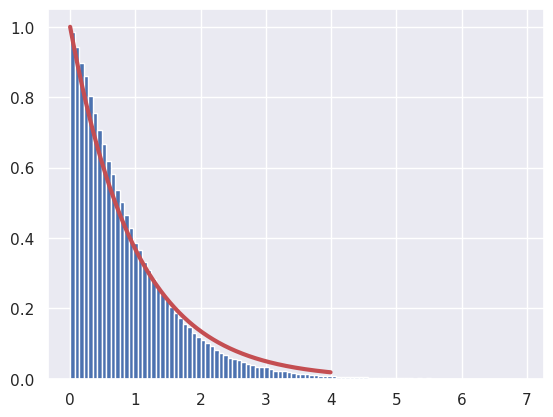

In [ ]:
plt.hist(post_smpl['s'][post_smpl['s'] > 0], bins=100, density=True);
x = jnp.arange(0, 4, 0.01)
plt.plot(x, jnp.exp(-x), 'r', lw=3)

In [ ]:
from numpyro.infer.autoguide import AutoNormal, AutoMultivariateNormal, AutoLowRankMultivariateNormal, AutoBNAFNormal

def guide1(n=100, d=16, k=8, m=8):
    AutoLowRankMultivariateNormal(global_vars, rank=10)(d, k, m)
    with numpyro.plate('data', n):
        loc = numpyro.param('loc', lambda rng_key: random.normal(rng_key, shape=(n, d)))
        scale = numpyro.param('scale', jnp.ones((n, d)), constraint=dist.constraints.softplus_positive)
        numpyro.sample('z', dist.Normal(loc=loc, scale=scale).to_event(1))

In [ ]:
from numpyro.infer import SVI, TraceGraph_ELBO, Predictive
from numpyro import handlers
from numpyro.optim import optax_to_numpyro
import optax

num_steps = 100_000
cm = handlers.condition(model1, data={'obs': smpl['obs'][0]})

loss = TraceGraph_ELBO(16)
optimizer = optax_to_numpyro(optax.adabelief(learning_rate=1e-3))

svi = SVI(cm, guide1, optimizer, loss)
rng_key, _rng_key = random.split(rng_key)
svi_res = svi.run(_rng_key, num_steps, d=32)

rng_key, _rng_key = random.split(rng_key)
svi_smpl = Predictive(cm, guide=guide1, params=svi_res.params, num_samples=1000)(_rng_key, d=32)

100%|██████████| 100000/100000 [01:52<00:00, 889.99it/s, init loss: 24060.0879, avg. loss [95001-100000]: 9217.8584]


In [ ]:
num_steps = 100_000
cm = handlers.condition(model1, data={'obs': smpl['obs'][0]})

guide = AutoLowRankMultivariateNormal(cm, rank=10)

loss = TraceGraph_ELBO(1)
optimizer = optax_to_numpyro(optax.adabelief(learning_rate=1e-3))

svi = SVI(cm, guide, optimizer, loss)
rng_key, _rng_key = random.split(rng_key)
svi_res = svi.run(_rng_key, num_steps, d=32)

rng_key, _rng_key = random.split(rng_key)
svi_smpl = Predictive(cm, guide=guide, params=svi_res.params, num_samples=1000)(_rng_key, d=32)

100%|██████████| 100000/100000 [01:20<00:00, 1242.23it/s, init loss: 23533.1191, avg. loss [95001-100000]: 8900.4092]


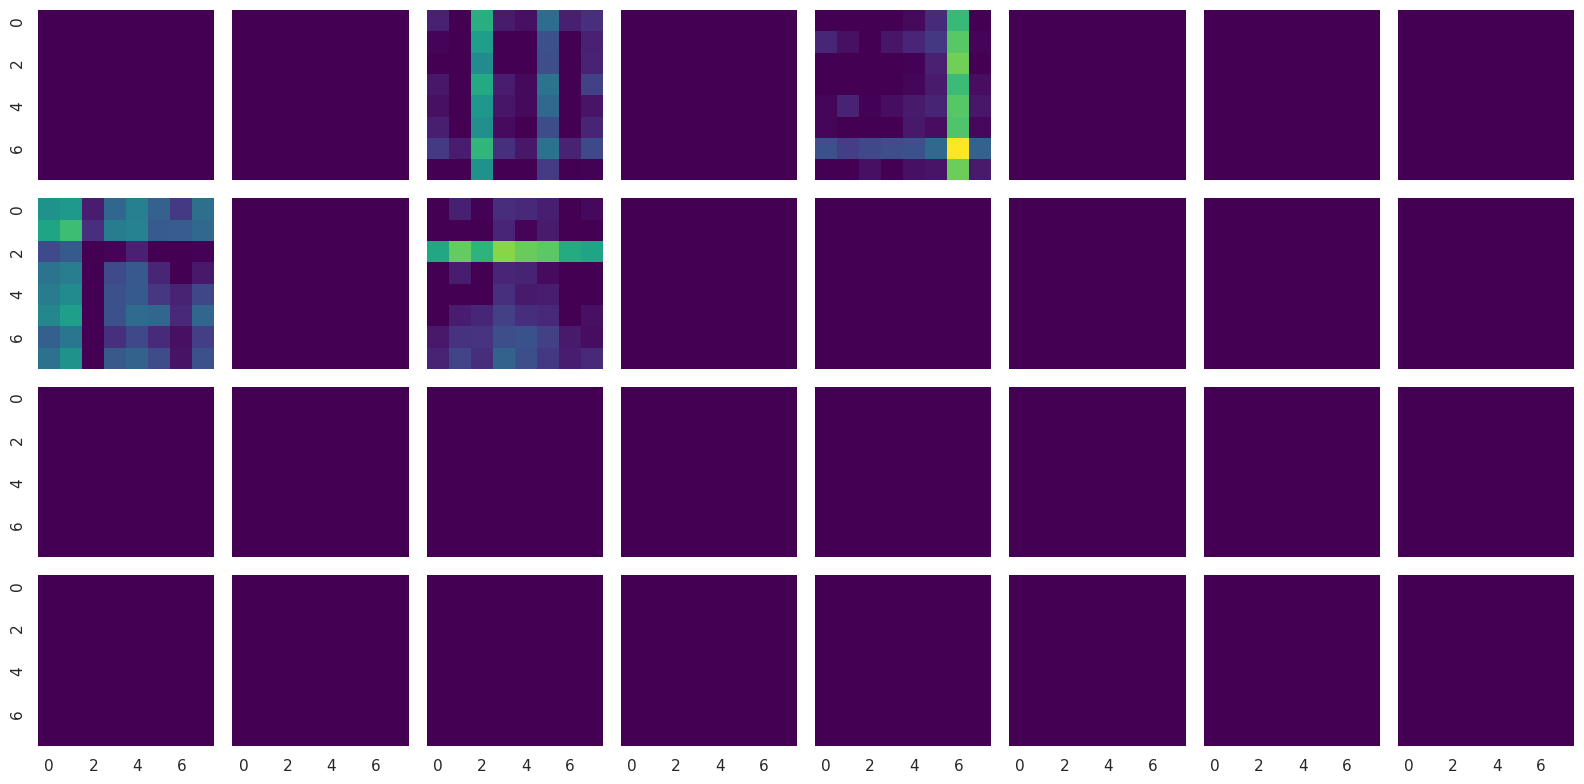

In [ ]:
W_post = svi_smpl['W'].mean(0)

fig, axes = plt.subplots(4, 8, figsize=(16, 8), sharex=True, sharey=True)

for i, w in enumerate(W_post):
    sns.heatmap(w, ax=axes.flatten()[i], cbar=False, vmax=1, vmin=0, cmap='viridis')

fig.tight_layout()

KeyboardInterrupt: 

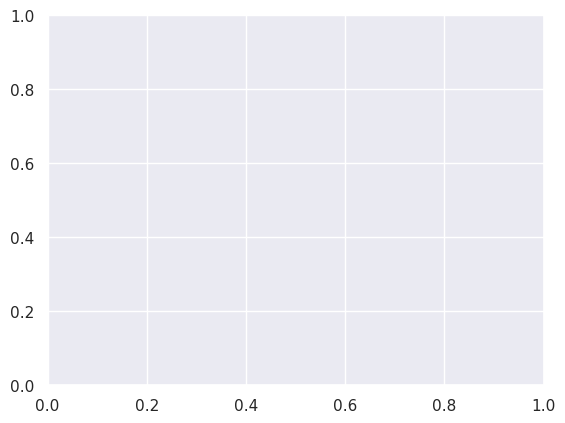

In [ ]:
plt.hist(svi_smpl['s'][svi_smpl['s'] > 0], bins=100, density=True);
x = jnp.arange(0, 4, 0.01)
plt.plot(x, jnp.exp(-x), 'r', lw=3)

In [ ]:
import equinox as eqx
from typing import Dict, Tuple, Callable
from numpyro.infer import log_likelihood
from jax import grad

def grad_neg_log_prob(z, obs, W, scale, u, lam):
    d, k, m = W.shape
    W = W.reshape(d, -1)
    
    x = jnp.abs(z)
    s = nn.relu(x - u)
    th = jnp.heaviside(x - u, 0.) * jnp.sign(z)
    
    grad_neg_lp = W @ (s @ W - obs.reshape(-1)) * th / scale ** 2 + lam * jnp.sign(z)

    return grad_neg_lp

class GradEnergyPotential(eqx.Module):
    model_args: Tuple
    model_kwargs: Dict
    params: Dict

    def __init__(self, args=(), kwargs={}, params={}):
        self.model_args = args
        self.model_kwargs = kwargs
        self.params = params

    def __call__(self, z, obs):
        return grad_neg_log_prob(z, obs, *self.model_args)

lam = 1
scale = 0.5
args = (W, scale, - jnp.log(0.2) / lam, lam)
grad_ep = GradEnergyPotential(args=args)

rng_key, _rng_key = random.split(rng_key)
z = random.normal(_rng_key, shape=W.shape[:1])
obs = smpl['obs'][0, 0]

%timeit grad_ep( z, obs )
print(grad_ep( z, obs ))

2.03 ms ± 3.24 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
[ 1.        1.        1.       -1.        1.        1.       -1.
 10.644641  1.       -1.        1.       -1.        1.        1.
 -1.        1.      ]


In [ ]:
class VectorField(eqx.Module):
    G: jnp.ndarray
    Q: jnp.ndarray
    nabla_E: Callable

    def __init__(self, dim, args, curl_strength=1.):
        self.G = jnp.eye(dim)
        
        L = dist.LKJCholesky(dim).sample(random.PRNGKey(0), sample_shape=(1,))[0]
        self.Q = curl_strength * (L - L.T)
        
        self.nabla_E = GradEnergyPotential(args=args)

    def __call__(self, t, z, args):
        v = self.nabla_E(z, args['obs'])
        return - self.G @ v - self.Q @ v

lam = 1.
u = - jnp.log(0.2) / lam
scale = 0.5
args = (W, scale, u, lam)
dim = W.shape[0]

vec_field = VectorField(dim, args, curl_strength=.1)

vec_field(0, random.normal(_rng_key, shape=W.shape[:1]), {'obs': smpl['obs'][0, 0]})

Array([ 0.92909086, -0.98851526, -1.0253857 , -1.1087147 ,  0.9571911 ,
       -1.1887827 ,  1.1720684 , -0.92863667,  0.9291013 , -1.0611241 ,
       -0.862831  ,  0.9026149 , -0.92210376,  1.0332586 ,  0.94919074,
        1.0413903 ], dtype=float32)

In [ ]:
from functools import partial 

def activation(u, x):
    return nn.relu(x - u)

class MirrorDescent(eqx.Module):    
    hidden_size: int
    W: Any
    V: Any
    a: Callable
    
    def __init__(self, hidden_size, W, u=-jnp.log(0.2), scale=1, **kwargs):
        super().__init__(**kwargs)
        self.hidden_size = hidden_size
        self.W = W.reshape(hidden_size, -1) / scale ** 2

        self.V = self.W @ self.W.T/scale**2 - jnp.eye(hidden_size)
        self.a = partial(activation, u)
        
    def __call__(self, t, z, args):
        s = self.a(z)
        return - z + self.W @ args['obs'].reshape(-1) - self.V @ s

rng_key = random.PRNGKey(0)
rng_key, _rng_key = random.split(rng_key)

mir_desc = MirrorDescent(W.shape[0], W, scale=0.1)
mir_desc(0, random.normal(_rng_key, shape=W.shape[:1]), {'obs': smpl['obs'][0, 0]})

Array([-2.4432572e+05, -2.4416639e+05, -2.4431745e+05, -2.4431972e+05,
       -2.4431814e+05, -2.4430623e+05, -2.4395770e+05, -2.4432428e+05,
        5.4349274e+02,  3.2123760e+01,  3.1008459e+02,  7.4469598e+02,
       -1.9589141e+06,  8.6031944e+01,  8.4868881e+01,  3.0778323e+03],      dtype=float32)

In [ ]:
from jax import lax

z_dim = W.shape[0]
scale = 1.
mir_desc = MirrorDescent(z_dim, W, scale=scale)
dt = 0.01
s = jnp.sqrt(2)
n = smpl['obs'][0].shape[0]

args = {'obs': smpl['obs'][0]}

def _heun(vec_field, dt, s, z, dW, args):
    g = vec_field(0, z, args)
    _z = z + g * dt + s * dW
    return z + dt * (vec_field(0, _z, args) + g) / 2 + s * dW

heun = partial(_heun, mir_desc, dt, s)

def step_fn(carry, t):
    z, rng_key = carry
    rng_key, _rng_key = random.split(rng_key)
    dW = jnp.sqrt(dt) * random.normal(_rng_key, shape=(n, z_dim))
    z_new = vmap(heun)(z, dW, args)
    return (z_new, rng_key), z_new

rng_key, _rng_key = random.split(rng_key)
z_init = random.normal(_rng_key, shape=(n, z_dim))

last, z = lax.scan(step_fn, (z_init, rng_key), jnp.arange(10_000))
s = mir_desc.a(z)


In [ ]:
z_dim = W.shape[0]
lam = 1.
scale = 0.5
args = (W, scale, - jnp.log(0.2)/lam, lam)
vec_field = VectorField(z_dim, args, curl_strength=10.)

def _heun(vf, dt, s, z, dW, args):
    g = vf(0, z, args)
    _z = z + g * dt + s * dW
    return z + dt * (vf(0, _z, args) + g) / 2 + s * dW

dt = 1e-3
s = jnp.sqrt(2)
heun = partial(_heun, vec_field, dt, s)

n = smpl['obs'].shape[1]

def step_fn(carry, t):
    z, args, rng_key = carry
    rng_key, _rng_key = random.split(rng_key)
    dW = jnp.sqrt(dt) * random.normal(_rng_key, shape=(n, z_dim))
    z_new = vmap(heun)(z, dW, args)
    return (z_new, args, rng_key), z_new

rng_key, _rng_key = random.split(rng_key)
args = {'obs': smpl['obs'][0]}
z_init = jnp.zeros((n ,z_dim)) # random.normal(_rng_key, shape=(n, z_dim))
n_steps = 100_000
last, z = lax.scan(step_fn, (z_init, args, rng_key), jnp.arange(n_steps))

In [ ]:
z.shape

(100000, 100, 16)

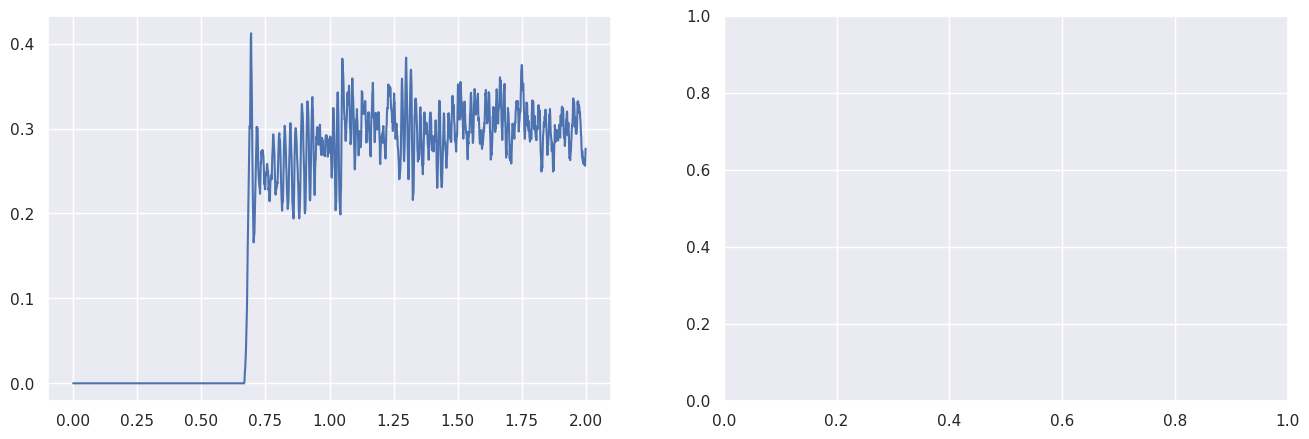

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
s = nn.relu(jnp.abs(z) + jnp.log(0.2))
ts = jnp.arange(n_steps) * dt

axes[0].plot(ts[:2000], s[:2000, 20].mean(-1))
# axes[0].hlines(0.2, 0, ts[-1], 'r', linestyle='--')

# s = s[-100:]
# axes[1].hist(s[s > 0], bins=100, density=True);
# x = jnp.arange(0, 6, 0.01)
# plt.plot(x, jnp.exp(-x), 'r', lw=3)

In [ ]:
import diffrax

class SparseSDE(eqx.Module):
    vf: Callable  # drift
    z_dim: int

    def __init__(
        self,
        vector_field,
        z_dim,
        **kwargs
    ):
        super().__init__(**kwargs)
        self.vf = vector_field
        self.z_dim = z_dim
        
    def __call__(self, ts, dt0, *, obs, key):
        t0 = ts[0]
        t1 = ts[-1]
        
        init_key, bm_key = random.split(key, 2)
        z0 = random.normal(init_key, (self.z_dim,))

        diffusion = lambda t, y, args: jnp.sqrt(2) * jnp.ones(self.z_dim)

        vf = diffrax.ODETerm(self.vf)  # Drift term

        brownian_motion = diffrax.VirtualBrownianTree(
            t0=t0, t1=t1, tol=dt0 / 2, shape=(self.z_dim,), key=bm_key
        )

        terms = diffrax.MultiTerm(vf, diffrax.ControlTerm(diffusion, brownian_motion))

        solver = diffrax.Heun()

        args = {'obs': obs}
        
        saveat = diffrax.SaveAt(ts=ts)
        sol = diffrax.diffeqsolve(terms, solver, t0, t1, dt0, z0, args=args, saveat=saveat, max_steps=1000_000)
        return sol

In [ ]:
z_dim = W.shape[0]
mir_desc = MirrorDescent(z_dim, W, u=-jnp.log(0.2))

args = {'obs': smpl['obs'][0, 0]}

solve_sde = SparseSDE(mir_desc, z_dim, args)
ts = jnp.arange(0, 10, .05)

rng_key, _rng_key = random.split(rng_key)
sol = solve_sde(ts, dt0=0.001, key=_rng_key)

In [ ]:
z_dim = W.shape[0]
lam = 1.
scale = 0.5
u = - jnp.log(0.2)/lam
args = (W, scale, u, lam)

vec_field = VectorField(z_dim, args, curl_strength=0.1)

solve_sde = SparseSDE(vec_field, z_dim)
ts = jnp.arange(0, 5, .01)

dt0 = 5 * 1e-3
rng_key, _rng_key = random.split(rng_key)
ssde = partial(solve_sde, ts, dt0)
sol = vmap(ssde)(key=random.split(_rng_key, smpl['obs'].shape[1]), obs=smpl['obs'][0])

s = nn.relu( jnp.abs(sol.ys) - u)

2023-03-30 18:18:26.958314: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:606] fastpath_data is none


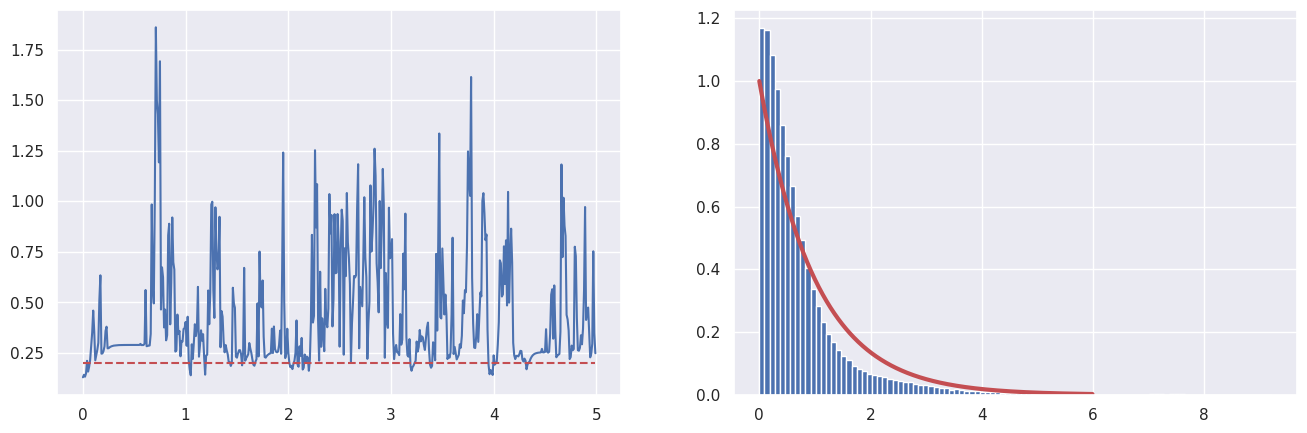

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

axes[0].plot(ts, s[0].mean(-1))
axes[0].hlines(0.2, 0, ts[-1], 'r', linestyle='--')

axes[1].hist(s[s > 0], bins=100, density=True);
x = jnp.arange(0, 6, 0.01)
plt.plot(x, jnp.exp(-x), 'r', lw=3)